# Experiments with kernel machines

In this notebook we will use simple two-dimensional data sets to illustrate the behavior of the support vector machine and the Perceptron, when used with quadratic and RBF kernels.

## 1. Basic training procedure

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The directory containing this notebook should also contain two-dimensional data files, `data1.txt` through `data5.txt`. These files contain one data point per line, along with a label (either -1 or 1), like:
* `3 8 -1` (meaning that point `x=(3,8)` has label `y=-1`)

The next procedure, **learn_and_display_SVM**, loads one of these data sets, invokes `sklearn.SVC` to learn a classifier, and then displays the data as well as the boundary. It is invoked as follows:
* `learn_and_display_SVM(datafile, kernel_type, C_value, s_value)`

where
* `datafile` is one of `'data1.txt'` through `'data5.txt'` (or another file in the same format)
* `kernel_type` is either `'quadratic'` or `'rbf'`
* `C_value` is the setting of the soft-margin parameter `C` (default: 1.0)
* `s_value` (for the RBF kernel) is the scaling parameter `s` (default: 1.0)

In [2]:
def learn_and_display_SVM(datafile, kernel_type='rbf', C_value=1.0, s_value=1.0):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Now train a support vector machine and identify the support vectors
    if kernel_type == 'rbf':
        clf = SVC(kernel='rbf', C=C_value, gamma=1.0/(s_value*s_value))
    if kernel_type == 'quadratic':
        clf = SVC(kernel='poly', degree=2, C=C_value, coef0=1.0)
    clf.fit(x,y)
    sv = np.zeros(n,dtype=bool)
    sv[clf.support_] = True
    notsv = np.logical_not(sv)
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points, enlarging those that are support vectors
    plt.plot(x[(y==1)*notsv,0], x[(y==1)*notsv,1], 'ro')
    plt.plot(x[(y==1)*sv,0], x[(y==1)*sv,1], 'ro', markersize=10)
    plt.plot(x[(y==-1)*notsv,0], x[(y==-1)*notsv,1], 'k^')
    plt.plot(x[(y==-1)*sv,0], x[(y==-1)*sv,1], 'k^', markersize=10)
    # Construct a grid of points and evaluate classifier at each grid points
    grid_spacing = 0.05
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = clf.decision_function(grid)
    # Quantize the values to -1, -0.5, 0, 0.5, 1 for display purposes
    for i in range(len(Z)):
        Z[i] = min(Z[i],1.0)
        Z[i] = max(Z[i],-1.0)
        if (Z[i] > 0.0) and (Z[i] < 1.0):
            Z[i] = 0.5
        if (Z[i] < 0.0) and (Z[i] > -1.0):
            Z[i] = -0.5
    # Show boundary and margin using a color plot
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.PRGn, vmin=-2, vmax=2)
    plt.show()

## 2. Experiments with the quadratic kernel

Let's try out SVM on some examples, starting with the quadratic kernel.

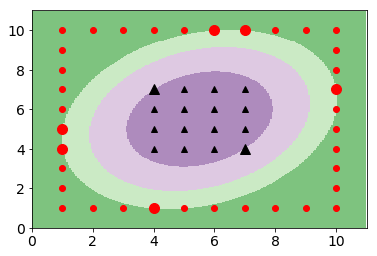

In [3]:
learn_and_display_SVM('data1.txt', 'quadratic', 1.0)

Also try `data2.txt` through `data5.txt`. Also try changing the value of `C` (the third parameter) to see how that affects the boundary and margin.

## 3. Experiments with the RBF kernel

Now experiment with the RBF kernel, on the same five data sets. This time there are two parameters to play with: `C` and `sigma`.

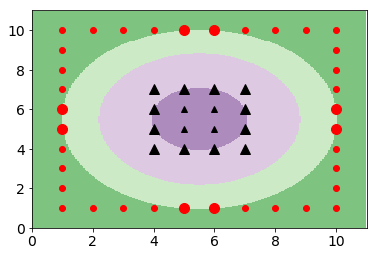

In [4]:
learn_and_display_SVM('data1.txt', 'rbf', 10.0, 10.0)

## 4. The kernel Perceptron

<font color="magenta">**For you to do:**</font> Implement the kernel Perceptron algorithm as specified in lecture. Your algorithm should allow both the quadratic and RBF kernel, and should follow roughly the same signature as the SVM routine above:
* `learn_and_display_Perceptron(datafile, kernel_type, s_value)`

Recall that the Perceptron algorithm does not always converge; you will need to explicitly check for this.

In [31]:
### 
### Any auxiliary functions that you need
###
def learn_and_display_Perceptron(datafile, kernel_type='rbf', s_value=1.0):
    ###
    ### Your code
    data = np.loadtxt(datafile)
    n,d = data.shape
    x = data[:, :2]
    y = data[:,2]
    w = np.zeros(d-1)
    b = 0
    for i in range(n):
        wx_b = np.dot(x[i],w) 
        wx_b+= b
        if wx_b*y[i] <= 0:
            w = w + s_value*y[i]*x[i]
            b = b + y[i]
            print()
    
    print(w)
    print(b)
    return w,b
    ###
def predict(X, w, b):
    X = np.atleast_2d(X)
    return np.sign(np.dot(X, w) + b)

In [40]:
w, b = learn_and_display_Perceptron('data3.txt', 'rbf', 1.0)
y_pred = predict(x, w, b)
correct = np.sum(y_pred == y)
print ("%d out of %d predictions correct" % (correct, len(y_pred)))

[ 19. -13.]
-1.0
28 out of 60 predictions correct


<font color="magenta">Experiment with your routine, on the same five data sets.</font>

In [68]:
class Perceptron(object):

    def __init__(self, T=1):
        self.T = T

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features, dtype=np.float64)
        self.b = 0.0

        for t in range(self.T):
            for i in range(n_samples):
                if self.predict(X[i])[0] != y[i]:
                    self.w += y[i] * X[i]
                    self.b += y[i]

    def project(self, X):
        return (np.dot(X, self.w) + self.b)*(np.dot(X, self.w) + self.b)

    def predict(self, X):
        X = np.atleast_2d(X)
        return np.sign(self.project(X))

In [81]:
clf = Perceptron(T=150)
data = np.loadtxt('data5.txt')
x = data[:, :2]
y = data[:,2]
clf.fit(x, y)

y_predict = clf.predict(x)
correct = np.sum(y_predict == y)
print ("%d out of %d predictions correct" % (correct, len(y_predict)))

40 out of 60 predictions correct


### 

In [119]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=2):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class KernelPerceptron(object):

    def __init__(self, kernel=linear_kernel, T=1):
        self.kernel = kernel
        self.T = T

    def fit(self, X, y):
        n_samples, n_features = X.shape
        #np.hstack((X, np.ones((n_samples, 1))))
        self.alpha = np.zeros(n_samples, dtype=np.float64)

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        for t in range(self.T):
            for i in range(n_samples):
                if np.sign(np.sum(K[:,i] * self.alpha * y)) != y[i]:
                    self.alpha[i] += 1.0

        # Support vectors
        sv = self.alpha > 1e-5
        ind = np.arange(len(self.alpha))[sv]
        self.alpha = self.alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print ("%d support vectors out of %d points" % (len(self.alpha),
                                                       n_samples))

    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict

    def predict(self, X):
        X = np.atleast_2d(X)
        n_samples, n_features = X.shape
        #np.hstack((X, np.ones((n_samples, 1))))
        return np.sign(self.project(X))

In [123]:
clf = KernelPerceptron(gaussian_kernel, T=1000)
data = np.loadtxt('data3.txt')
x = data[:, :2]
y = data[:,2]
clf.fit(x, y)

y_predict = clf.predict(x)
correct = np.sum(y_predict == y)
print ("%d out of %d predictions correct" % (correct, len(y_predict)))

22 support vectors out of 90 points
90 out of 90 predictions correct
